# Video-based fight detection using deep learning 

*Author: Fourat Thamri*

*This jupyter notebook constitutes the submission for the Aviva assessment test for the Machine Learning engineer position.*

#### This notebook explores two different deep learning architectures for video classification, namely a transformer-based **ViVIT** (Video Vision Transformer ) a **CNN-RNN** which uses extracted features from Incevtion-V3 from each frame and pass them as a sequence to a RNN classifier.

#### Due to the small size of the provided dataset, the models tend to overfit quickly. So I added another dataset for surveillance-video fight detection from a public github repo to enriche the data and enhance generalibility of models. 

Note: The notebook is meant to be run sequentially from start to finish in a kaggle notebook created from the provided dataset link so that data gets downloaded automatically without having to use Kaggle API  

References 
* ViViT: https://keras.io/examples/vision/vivit/
* CNN-RNN: https://keras.io/examples/vision/video_classification/
* Vision-based Fight Detection From Surveillance Cameras Dataset: https://github.com/seymanurakti/fight-detection-surv-dataset


## Import libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt 
import skvideo.io  
import os 
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import io
import imageio
import ipywidgets
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K


## Install Scikit-Video

In [7]:
!pip install scikit-video

## Add surveillance fight dataset from github

In [8]:
!git clone https://github.com/seymanurakti/fight-detection-surv-dataset.git

fatal: destination path 'fight-detection-surv-dataset' already exists and is not an empty directory.


## Load, resize and trim the videos

In [77]:
def frame_crop_center(video,cropf):
    f,_,_,_ = video.shape
    startf = f//2 - cropf//2
    return video[startf:startf+cropf, :, :, :]

fights=[]
nofights=[]

surv_fights=[]
surv_no_fights=[]

video_dims = []

####### Fight data
for filename in os.listdir('fights')[:2]:
    print(1, filename)
    f = os.path.join('fights', filename)
    # checking if it is a file
    video = skvideo.io.vread(f)
    video_dims.append(video.shape)
    L=[]
    
    #resize video dimensions
    for i in range(video.shape[0]):
      frame = cv2.resize(video[i], (128,128), interpolation=cv2.INTER_CUBIC)
      L.append(frame)

    video = np.asarray(L)
    
    #center crop video to have consistent video frame number
    video = frame_crop_center(video, 42)
    
    fights.append(video)

for filename in os.listdir('fights')[:2]:
    print(2, filename)
    f = os.path.join('fights', filename)
    # checking if it is a file
    video = skvideo.io.vread(f)
    video_dims.append(video.shape)
    
    L=[]
    for i in range(video.shape[0]):
      frame = cv2.resize(video[i], (128,128), interpolation=cv2.INTER_CUBIC)
      L.append(frame)

    video = np.asarray(L)
    video = frame_crop_center(video, 42)
    
    surv_fights.append(video)

####### Non Fight data
for filename in os.listdir('noFights')[:2]:
    print(3, filename)
    f = os.path.join('noFights', filename)
    # checking if it is a file
    video = skvideo.io.vread(f)
    video_dims.append(video.shape)
    
    L=[]
    for i in range(video.shape[0]):
      frame = cv2.resize(video[i], (128,128), interpolation=cv2.INTER_CUBIC)
      L.append(frame)

    video = np.asarray(L)
    video = frame_crop_center(video, 42)

    nofights.append(video)

for filename in os.listdir('noFights')[:2]:
    print(4, filename)
    f = os.path.join('noFights', filename)
    # checking if it is a file
    video = skvideo.io.vread(f) 
    video_dims.append(video.shape)

    L=[]
    for i in range(video.shape[0]):
      frame = cv2.resize(video[i], (128,128), interpolation=cv2.INTER_CUBIC)
      L.append(frame)

    video = np.asarray(L)
    video = frame_crop_center(video, 42)

    surv_no_fights.append(video)

1 fi003.mp4
1 fi017.mp4
2 fi003.mp4
2 fi017.mp4
3 nofi038.mp4
3 nofi010.mp4
4 nofi038.mp4
4 nofi010.mp4


## Video duration and dimension analysis 

The mean number of frames in the videos is 54 which corresponds to around 2 seconds. 
To make the video duration consistent without losing lots of data the videos are trimmed to have 42 frames in total with a center crop. 

Using a smaller frame number results in poorer performance. 

In [78]:
data= pd.DataFrame(video_dims, columns=['frame_length', 'height', 'width', 'channels'])
data.describe()

,frame_length,height,width,channels
count,8.000000,8.000000,8.000000,8.0
mean,62.250000,630.000000,1080.000000,3.0
std,2.659216,319.105894,609.261848,0.0
min,60.000000,360.000000,480.000000,3.0
25%,60.000000,360.000000,600.000000,3.0
50%,61.500000,540.000000,960.000000,3.0
75%,63.750000,810.000000,1440.000000,3.0
max,66.000000,1080.000000,1920.000000,3.0


## Aggregate data and create labels 

In [79]:
surv_fights = [video for video in surv_fights if video.shape[0] == 42]
surv_no_fights = [video for video in surv_no_fights if video.shape[0] == 42]

videos = fights + surv_fights + nofights + surv_no_fights
videos = np.asarray(videos, dtype=object)

labels = np.concatenate([np.ones(len(fights)+len(surv_fights)) , np.zeros(len(nofights)+len(surv_no_fights))])

# del fights
# del nofights
# del surv_fights
# del surv_no_fights

## Train, test, val split 

In [80]:
X_train, X_test, y_train, y_test = train_test_split(videos, labels, test_size=0.2, random_state=2334)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=124567)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(5, 42, 128, 128, 3)
(1, 42, 128, 128, 3)
(2, 42, 128, 128, 3)


## Set ViVit model hyperparameters 

In [81]:
# Setting seed for reproducibility
SEED = 77
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
tf.random.set_seed(SEED)

# DATA
DATASET_NAME = "fight/nofights"
BATCH_SIZE = 4
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (42, 128, 128, 3)
NUM_CLASSES = 2

# OPTIMIZER
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

# TRAINING
EPOCHS = 20

# TUBELET EMBEDDING
PATCH_SIZE = (8, 8, 8)
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE[0]) ** 2

# ViViT ARCHITECTURE
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 64
NUM_HEADS = 2
NUM_LAYERS = 2

## Preprocess and prepare dataloader

Takes around 5 ~ 10 minutes to execute

In [82]:
@tf.function
def preprocess(frames: tf.Tensor, label: tf.Tensor):
    """Preprocess the frames tensors and parse the labels"""
    # Preprocess images
    frames = tf.image.convert_image_dtype(
        frames[
            ..., tf.newaxis
        ],  # The new axis is to help for further processing with Conv3D layers
        tf.float32,
    )

    # Parse label
    label = tf.cast(label, tf.float32)
    return frames, label


def  prepare_dataloader(
    videos,
    labels,
    loader_type: str = "train",
    batch_size: int = BATCH_SIZE,
):
    """Utility function to prepare dataloader"""
    dataset = tf.data.Dataset.from_tensor_slices((videos, labels))

    if loader_type == "train":
        dataset = dataset.shuffle(BATCH_SIZE * 2)

    dataloader = (
        dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

    return dataloader


# x_train = np.asarray(X_train)
# y_train = np.asarray(y_train)

# print(type(1))

trainloader = prepare_dataloader(tf.ragged.constant(X_train), tf.ragged.constant(y_train), "train")
print(123)
validloader = prepare_dataloader(X_val.tolist(), y_val.tolist(), "valid")
testloader = prepare_dataloader(X_test.tolist(), y_test.tolist(), "test")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
123


## Define some model classes 

In [83]:
class TubeletEmbedding(layers.Layer):
    def __init__(self, embed_dim, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.projection = layers.Conv3D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding="VALID",
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))

    def call(self, videos):
        projected_patches = self.projection(videos)
        flattened_patches = self.flatten(projected_patches)
        return flattened_patches

class PositionalEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(
            input_dim=num_tokens, output_dim=self.embed_dim
        )
        self.positions = tf.range(start=0, limit=num_tokens, delta=1)

    def call(self, encoded_tokens):
        # Encode the positions and add it to the encoded tokens
        encoded_positions = self.position_embedding(self.positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens

## Create model 

In [84]:
def create_vivit_classifier(
    tubelet_embedder,
    positional_encoder,
    input_shape=INPUT_SHAPE,
    transformer_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    embed_dim=PROJECTION_DIM,
    layer_norm_eps=LAYER_NORM_EPS,
    num_classes=NUM_CLASSES,
):
    # Get the input layer
    inputs = layers.Input(shape=input_shape)
    # Create patches.
    patches = tubelet_embedder(inputs)
    # Encode patches.
    encoded_patches = positional_encoder(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization and MHSA
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.1
        )(x1, x1)

        # Skip connection
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer Normalization and MLP
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = keras.Sequential(
            [
                layers.Dense(units=embed_dim * 4, activation=tf.nn.gelu),
                layers.Dense(units=embed_dim, activation=tf.nn.gelu),
            ]
        )(x3)

        # Skip connection
        encoded_patches = layers.Add()([x3, x2])

    # Layer normalization and Global average pooling.
    representation = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
    representation = layers.GlobalAvgPool1D()(representation)

    # Classify outputs.
    outputs = layers.Dense(units=num_classes, activation="softmax")(representation)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

## Define metrics, build, train and save ViVit model

In [86]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def run_experiment():
    # Initialize model
    model = create_vivit_classifier(
        tubelet_embedder=TubeletEmbedding(
            embed_dim=PROJECTION_DIM, patch_size=PATCH_SIZE
        ),
        positional_encoder=PositionalEncoder(embed_dim=PROJECTION_DIM),
    )

    # Compile the model with the optimizer, loss function
    # and the metrics.
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            recall_m,
            precision_m,
            f1_m,
        ],
    )

    # Train the model.
    _ = model.fit(trainloader, epochs=EPOCHS, validation_data=validloader)

    _, accuracy, recall, precision, f1 = model.evaluate(testloader)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test recall: {round(recall * 100, 2)}%")
    print(f"Test precision: {round(precision * 100, 2)}%")
    print(f"Test F1: {round(f1 * 100, 2)}%")
    
    vivit_scores = [accuracy, recall, precision, f1]
    return model, vivit_scores


model, vivit_scores = run_experiment()

model.save('vivit_model')


Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ValueError: Exception encountered when calling layer 'tubelet_embedding_1' (type TubeletEmbedding).

Input 0 of layer "conv3d_1" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (None, None, None, None, None, 1)

Call arguments received by layer 'tubelet_embedding_1' (type TubeletEmbedding):
  • videos=tf.RaggedTensor(values=tf.RaggedTensor(values=tf.RaggedTensor(values=tf.RaggedTensor(values=Tensor("RaggedFromVariant/RaggedTensorFromVariant:4", shape=(None, 1), dtype=float32), row_splits=Tensor("RaggedFromVariant/RaggedTensorFromVariant:3", shape=(None,), dtype=int64)), row_splits=Tensor("RaggedFromVariant/RaggedTensorFromVariant:2", shape=(None,), dtype=int64)), row_splits=Tensor("RaggedFromVariant/RaggedTensorFromVariant:1", shape=(None,), dtype=int64)), row_splits=Tensor("RaggedFromVariant/RaggedTensorFromVariant:0", shape=(None,), dtype=int64))

### Plot Confusion Matrix

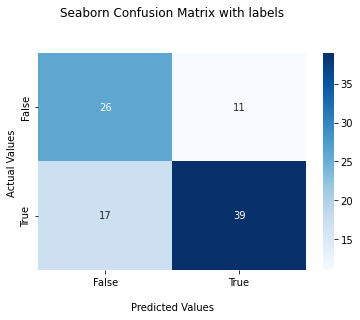

In [18]:
y_preds = np.argmax(model.predict(testloader), axis=1)

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_preds)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()
ax.figure.savefig("vivit_cf.png") 


### Visualise predictions 

In [19]:
NUM_SAMPLES_VIZ = 25

testsamples, labels_ = next(iter(testloader))
testsamples, labels_ = X_test[:NUM_SAMPLES_VIZ], y_test[:NUM_SAMPLES_VIZ]

ground_truths = []
preds = []
videos_ = []

for i, (testsample, label) in enumerate(zip(testsamples, labels_)):
    # Generate gif
    with io.BytesIO() as gif:
        imageio.mimsave(gif, (testsample * 255).astype("uint8"), "GIF", fps=5)
        videos_.append(gif.getvalue())

    # Get model prediction
    output = model.predict(tf.expand_dims(testsample, axis=0))[0]
    pred = np.argmax(output, axis=0)

    ground_truths.append(label.astype("int"))
    preds.append(pred)


def make_box_for_grid(image_widget, fit):
    """Make a VBox to hold caption/image for demonstrating option_fit values.

    Source: https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Styling.html
    """
    # Make the caption
    if fit is not None:
        fit_str = "'{}'".format(fit)
    else:
        fit_str = str(fit)

    h = ipywidgets.HTML(value="" + str(fit_str) + "")

    # Make the green box with the image widget inside it
    boxb = ipywidgets.widgets.Box()
    boxb.children = [image_widget]

    # Compose into a vertical box
    vb = ipywidgets.widgets.VBox()
    vb.layout.align_items = "center"
    vb.children = [h, boxb]
    return vb


boxes = []
label_dict = {0: 'noFight', 1: 'Fight'}
for i in range(NUM_SAMPLES_VIZ):
    ib = ipywidgets.widgets.Image(value=videos_[i], width=200, height=200)
    true_class = label_dict[ground_truths[i]]
    pred_class = label_dict[preds[i]]
    caption = f"T: {true_class} | P: {pred_class}"

    boxes.append(make_box_for_grid(ib, caption))

ipywidgets.widgets.GridBox(
    boxes, layout=ipywidgets.widgets.Layout(grid_template_columns="repeat(5, 200px)")
)

GridBox(children=(VBox(children=(HTML(value="'T: Fight | P: noFight'"), Box(children=(Image(value=b'GIF89a\x80…

# *CNN-RNN model*

### Build Inception V3 feature extractor 

In [20]:
IMG_SIZE = 128

def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

### Create masks, process and prepare data

Takes around 10 ~ 20 minutes to execute

In [21]:
MAX_SEQ_LENGTH = 42
NUM_FEATURES = 2048

def prepare_all_videos():
    num_samples = len(videos)
    
    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx in range(len(videos)):
        # Gather all its frames and add a batch dimension.
        if idx % 25 == 0:
            print(idx,'/',len(videos), ' videos prepared')
        frames = videos[idx][None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks)


processed_data = prepare_all_videos()

0 / 461  videos prepared
25 / 461  videos prepared
75 / 461  videos prepared
100 / 461  videos prepared
125 / 461  videos prepared
150 / 461  videos prepared
175 / 461  videos prepared
200 / 461  videos prepared
225 / 461  videos prepared
250 / 461  videos prepared
275 / 461  videos prepared
300 / 461  videos prepared
325 / 461  videos prepared
350 / 461  videos prepared
375 / 461  videos prepared
400 / 461  videos prepared
425 / 461  videos prepared
450 / 461  videos prepared


In [22]:
processed_data[0].shape

(461, 42, 2048)

### Train, test split 

In [23]:
X_train_features, X_test_features, y_train, y_test = train_test_split(processed_data[0], labels, test_size=0.2, random_state=2334)
X_train_masks, X_test_masks, y_train, y_test = train_test_split(processed_data[1], labels, test_size=0.2, random_state=2334)


print(X_train_features.shape)
print(X_test_features.shape)

(368, 42, 2048)
(93, 42, 2048)


### Build train and evaluate model 

In [24]:
# Utility for our sequence model.
def get_sequence_model():
    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(2, activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy", recall_m, precision_m, f1_m]
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [X_train_features, X_train_masks],
        y_train,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy, recall, prec, f1 = seq_model.evaluate([X_test_features, X_test_masks], y_test)

    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test recall: {round(recall * 100, 2)}%")
    print(f"Test precision: {round(prec * 100, 2)}%")
    print(f"Test F1: {round(f1 * 100, 2)}%")
    cnn_rnn_scores = [accuracy, recall, prec, f1]


    return history, seq_model, cnn_rnn_scores


_, sequence_model, cnn_rnn_scores = run_experiment()

sequence_model.save('cnn_rnn_model')

Epoch 1/20
9/9 [==============================] - 10s 363ms/step - loss: 0.6950 - accuracy: 0.5798 - recall_m: 1.0000 - precision_m: 0.5590 - f1_m: 0.7032 - val_loss: 0.6243 - val_accuracy: 0.6667 - val_recall_m: 1.0000 - val_precision_m: 0.4771 - val_f1_m: 0.6433

Epoch 00001: val_loss improved from inf to 0.62426, saving model to /tmp/video_classifier
Epoch 2/20
9/9 [==============================] - 0s 32ms/step - loss: 0.6780 - accuracy: 0.5447 - recall_m: 0.8889 - precision_m: 0.4514 - f1_m: 0.5938 - val_loss: 0.6392 - val_accuracy: 0.6216 - val_recall_m: 1.0000 - val_precision_m: 0.4771 - val_f1_m: 0.6433

Epoch 00002: val_loss did not improve from 0.62426
Epoch 3/20
9/9 [==============================] - 0s 24ms/step - loss: 0.6294 - accuracy: 0.6381 - recall_m: 0.8889 - precision_m: 0.4514 - f1_m: 0.5962 - val_loss: 0.5873 - val_accuracy: 0.6937 - val_recall_m: 1.0000 - val_precision_m: 0.4771 - val_f1_m: 0.6433

Epoch 00003: val_loss improved from 0.62426 to 0.58728, saving mo

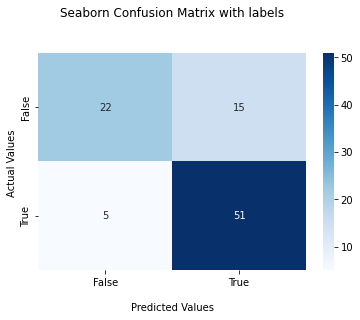

In [25]:
y_preds = np.argmax(sequence_model.predict([X_test_features, X_test_masks]), axis=1)

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_preds)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()
ax.figure.savefig("cnn_rnn_cf.png") 


# Comparative results on test set 

The vivit classifier provides poor performance compare to the CNN-RNN architecture due to the very small size of the dataset. Transformer-based models have a large number of parameters thus require a big dataset otherwise they will be easily prone to overfitting. In the other side, the CNN-RNN architecture uses a pre-trained feature extractor instead of learning features from the provided dataset only. For this reason the CNN-RNN provided better results even with a very small dataset. 

In [26]:
df = pd.DataFrame([vivit_scores, cnn_rnn_scores])
df.columns= ['Accuracy', 'Recall', 'Precision', 'F1']
df.index = ['ViViT', 'CNN-RNN']

df.head()

,Accuracy,Recall,Precision,F1
ViViT,0.698925,0.958333,0.614583,0.730952
CNN-RNN,0.784946,1.000000,0.602730,0.751729


### Plot confusion matrices side by side 

[0.698924720287323, 0.9583333134651184, 0.6145833134651184, 0.7309524416923523]
[0.7849462628364563, 1.0, 0.602729856967926, 0.7517293095588684]


Text(0.5, 1.0, 'CNN-RNN CLASSIFIER')

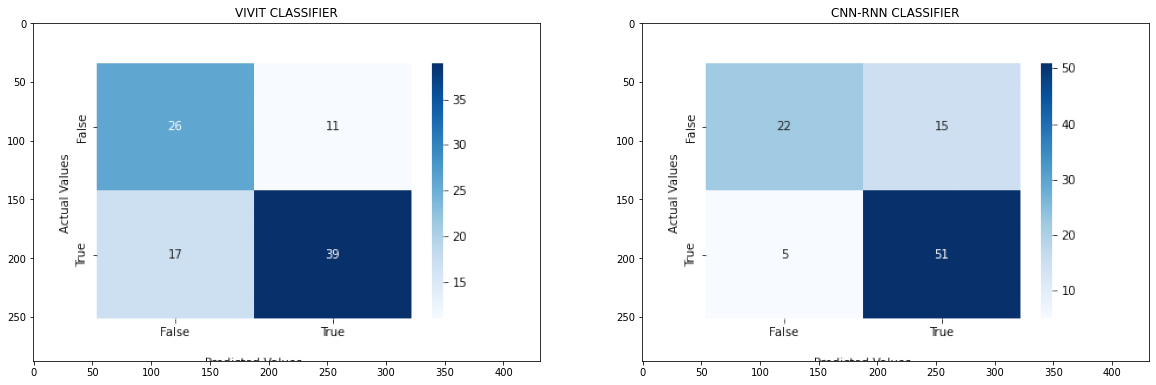

In [27]:
print(vivit_scores)
print(cnn_rnn_scores)

im1 = plt.imread('vivit_cf.png')
im2 = plt.imread('cnn_rnn_cf.png')

f, axarr = plt.subplots(1,2, figsize=(20,20))
axarr[0].imshow(im1)
axarr[0].set_title('VIVIT CLASSIFIER')
axarr[1].imshow(im2)
axarr[1].set_title('CNN-RNN CLASSIFIER')

## Model interpretability

Model features can be interpreted using the SHAP library

*Work in Progress*

In [ ]:
import shap

# select a set of background examples to take an expectation over
background = X_train_features[np.random.choice(X_train_features.shape[0], 100, replace=False)]

# explain predictions of the model on three images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(X_test[1:5])

shap.image_plot(shap_values, -X_test[1:5])
